# HW 1 Professionalism & Reproducibility

## Data Acquisition

Load the rare-disease names from the `rare-disease_cleaned.AUG.2024.csv`

In [2]:
import pandas as pd

diseases = pd.read_csv('/content/rare-disease_cleaned.AUG.2024.csv', usecols=['disease'])

Define constants for accessing the Wikimedia Pageviews API, including the base endpoint, request parameters, and configurations for latency and headers to ensure efficient data retrieval.

In [95]:
# These are standard python modules
import json, time, urllib.parse
#
# The 'requests' module is not a standard Python module. You will need to install this with pip/pip3 if you do not already have it
import requests

#########
#
#    CONSTANTS
#

# The REST API 'pageviews' URL - this is the common URL/endpoint for all 'pageviews' API requests
API_REQUEST_PAGEVIEWS_ENDPOINT = 'https://wikimedia.org/api/rest_v1/metrics/pageviews/'

# This is a parameterized string that specifies what kind of pageviews request we are going to make
# In this case it will be a 'per-article' based request. The string is a format string so that we can
# replace each parameter with an appropriate value before making the request
API_REQUEST_PER_ARTICLE_PARAMS = 'per-article/{project}/{access}/{agent}/{article}/{granularity}/{start}/{end}'

# The Pageviews API asks that we not exceed 100 requests per second, we add a small delay to each request
API_LATENCY_ASSUMED = 0.002       # Assuming roughly 2ms latency on the API and network
API_THROTTLE_WAIT = (1.0/100.0)-API_LATENCY_ASSUMED

# When making a request to the Wikimedia API they ask that you include your email address which will allow them
# to contact you if something happens - such as - your code exceeding rate limits - or some other error
REQUEST_HEADERS = {
    'User-Agent': 'jbjunguw@uw.edu, University of Washington, MSDS DATA 512 - AUTUMN 2024',
}

# This is just a list of English Wikipedia article titles that we can use for example requests
# ARTICLE_TITLES = [ 'Bison', 'Northern flicker', 'Red squirrel', 'Chinook salmon', 'Horseshoe bat' ]

# This template is used to map parameter values into the API_REQUST_PER_ARTICLE_PARAMS portion of an API request. The dictionary has a
# field/key for each of the required parameters. In the example, below, we only vary the article name, so the majority of the fields
# can stay constant for each request. Of course, these values *could* be changed if necessary.
ARTICLE_PAGEVIEWS_PARAMS_TEMPLATE = {
    "project":     "en.wikipedia.org",
    "access":      "",      # this should be changed for the different access types - mobile-app or desktop
    "agent":       "user",
    "article":     "",             # this value will be set/changed before each request
    "granularity": "monthly",
    "start":       "",   # start and end dates need to be set
    "end":         ""    # this is likely the wrong end date
}


Define `request_pageviews_per_article` to retrieve pageview data for a specified Wikipedia article by constructing an API request with the given parameters while handling rate limits and errors.

In [96]:
#########
#
#    PROCEDURES/FUNCTIONS
#

def request_pageviews_per_article(article_title = None,
                                  access_type = None,
                                  start_date = "2015070100",
                                  end_date = "2024093000",
                                  endpoint_url = API_REQUEST_PAGEVIEWS_ENDPOINT,
                                  endpoint_params = API_REQUEST_PER_ARTICLE_PARAMS,
                                  request_template = ARTICLE_PAGEVIEWS_PARAMS_TEMPLATE,
                                  headers = REQUEST_HEADERS):

    # article title can be as a parameter to the call or in the request_template
    if article_title:
        request_template['article'] = article_title

    if not request_template['article']:
        raise Exception("Must supply an article title to make a pageviews request.")

    # access type can be as a parameter to the call or in the request_template
    if access_type:
        request_template['access'] = access_type

    if not request_template['access']:
        raise Exception("Must supply an access type to make a pageviews request.")

    # start date can be as a parameter to the call or in the request_template
    if start_date:
        request_template['start'] = start_date

    if not request_template['start']:
        raise Exception("Must supply a start date to make a pageviews request.")

    # end date can be as a parameter to the call or in the request_template
    if end_date:
        request_template['end'] = end_date

    if not request_template['end']:
        raise Exception("Must supply a start date to make a pageviews request.")


    # Titles are supposed to have spaces replaced with "_" and be URL encoded
    article_title_encoded = urllib.parse.quote(request_template['article'].replace(' ','_'), safe='')
    request_template['article'] = article_title_encoded

    # now, create a request URL by combining the endpoint_url with the parameters for the request
    request_url = endpoint_url+endpoint_params.format(**request_template)

    # make the request
    try:
        # we'll wait first, to make sure we don't exceed the limit in the situation where an exception
        # occurs during the request processing - throttling is always a good practice with a free
        # data source like Wikipedia - or other community sources
        if API_THROTTLE_WAIT > 0.0:
            time.sleep(API_THROTTLE_WAIT)
        response = requests.get(request_url, headers=headers)
        json_response = response.json()
    except Exception as e:
        print('api timeout')
        print(e)
        json_response = None
    return json_response


Iterate through each disease name and fetch monthly pageview data for both desktop and mobile access types.

In [97]:
desktop_filename = "rare-disease_monthly_desktop_201507-202409.json"
mobile_filename = "rare-disease_monthly_mobile_201507-202409.json"
cumulative_filename = "rare-disease_monthly_cumulative_201507-202409.json"

all_desktop_data = []
all_mobile_data = []
all_cumulative_data = []

for disease in diseases['disease']:
    print(disease)

    # For desktop
    desktop_views = request_pageviews_per_article(article_title=disease, access_type="desktop")
    if 'items' in desktop_views:
        for month in desktop_views['items']:
            if 'access' in month:
                del month['access']
            all_desktop_data.append(month)
    else:
        print(f"Error fetching desktop views for {disease}: {desktop_views.get('detail', 'Unknown error')}")

    # For mobile
    mobile_app_views = request_pageviews_per_article(article_title=disease, access_type="mobile-app")
    if 'items' in mobile_app_views:
        for month in mobile_app_views['items']:
            if 'access' in month:
                del month['access']
            all_mobile_data.append(month)
    else:
        print(f"Error fetching mobile views for {disease}: {mobile_app_views.get('detail', 'Unknown error')}")

    mobile_web_views = request_pageviews_per_article(article_title=disease, access_type="mobile-web")
    if 'items' in mobile_app_views:
        for month in mobile_app_views['items']:
            if 'access' in month:
                del month['access']
            all_mobile_data.append(month)
    else:
        print(f"Error fetching mobile views for {disease}: {mobile_web_views.get('detail', 'Unknown error')}")


    # For all access
    all_views = request_pageviews_per_article(article_title=disease, access_type="all-access")
    if 'items' in all_views:
        for month in all_views['items']:
            if 'access' in month:
                del month['access']
            all_cumulative_data.append(month)
    else:
        print(f"Error fetching all views for {disease}: {all_views.get('detail', 'Unknown error')}")


Klinefelter syndrome
Aarskog–Scott syndrome
Abetalipoproteinemia
MT-TP
Ablepharon macrostomia syndrome
Acanthocheilonemiasis
Acanthosis nigricans
Aceruloplasminemia
Megaesophagus
Achard–Thiers syndrome
Achondrogenesis
Achondroplasia
Dwarfism
Osteochondrodysplasia
Fibroblast growth factor receptor 3
Vestibular schwannoma
Brain tumor
Acquired generalized lipodystrophy
Barraquer–Simons syndrome
Acrodermatitis enteropathica
Zinc deficiency
Brown-Séquard syndrome
Spinal cord injury
Brucellosis
Yellowstone Park bison herd
Māui dolphin
Brugada syndrome
Nav1.8
Sports cardiology
Budd–Chiari syndrome
Thrombosis
Hepatic veno-occlusive disease
Thromboangiitis obliterans
Bullous pemphigoid
Pemphigoid
Trigonocephaly
CADASIL
Campomelic dysplasia
Camurati–Engelmann disease
Canavan disease
Spongy degeneration of the central nervous system
Candidiasis
Breastfeeding difficulties
Cerebral autosomal recessive arteriopathy with subcortical infarcts and leukoencephalopathy
Carcinoid syndrome
Enterochromaffin

In [98]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Save the collected data to JSON files

In [99]:
with open(desktop_filename, 'w') as json_file:
    json.dump(all_desktop_data, json_file, indent=4)

with open(mobile_filename, 'w') as json_file:
    json.dump(all_mobile_data, json_file, indent=4)

with open(cumulative_filename, 'w') as json_file:
    json.dump(all_cumulative_data, json_file, indent=4)

## Maximum Average and Minimum Average

Convert the data into Pandas DataFrames for  analysis

In [100]:
import matplotlib.pyplot as plt

In [101]:
desktop_df = pd.DataFrame(all_desktop_data)
mobile_df = pd.DataFrame(all_mobile_data)

In [102]:
desktop_df['timestamp'] = pd.to_datetime(desktop_df['timestamp'].astype(str), format='%Y%m%d%H')
desktop_df['year_month'] = desktop_df['timestamp'].dt.to_period('M')

mobile_df['timestamp'] = pd.to_datetime(mobile_df['timestamp'].astype(str), format='%Y%m%d%H')
mobile_df['year_month'] = mobile_df['timestamp'].dt.to_period('M')

Group by the the article title and compute the mean of the views

In [103]:
desktop_avg = desktop_df.groupby('article')['views'].mean().reset_index()
mobile_avg = mobile_df.groupby('article')['views'].mean().reset_index()

Find the highest and lowest average views for  desktop and mobile

In [104]:
max_desktop = desktop_avg.loc[desktop_avg['views'].idxmax()]
min_desktop = desktop_avg.loc[desktop_avg['views'].idxmin()]
max_mobile = mobile_avg.loc[mobile_avg['views'].idxmax()]
min_mobile = mobile_avg.loc[mobile_avg['views'].idxmin()]

Get time series data for these identified articles from the original DataFrames

In [105]:
max_desktop_data = desktop_df[desktop_df['article'] == max_desktop['article']]
min_desktop_data = desktop_df[desktop_df['article'] == min_desktop['article']]
max_mobile_data = mobile_df[mobile_df['article'] == max_mobile['article']]
min_mobile_data = mobile_df[mobile_df['article'] == min_mobile['article']]

Visualize the pageview trends for the articles with the highest and lowest average views

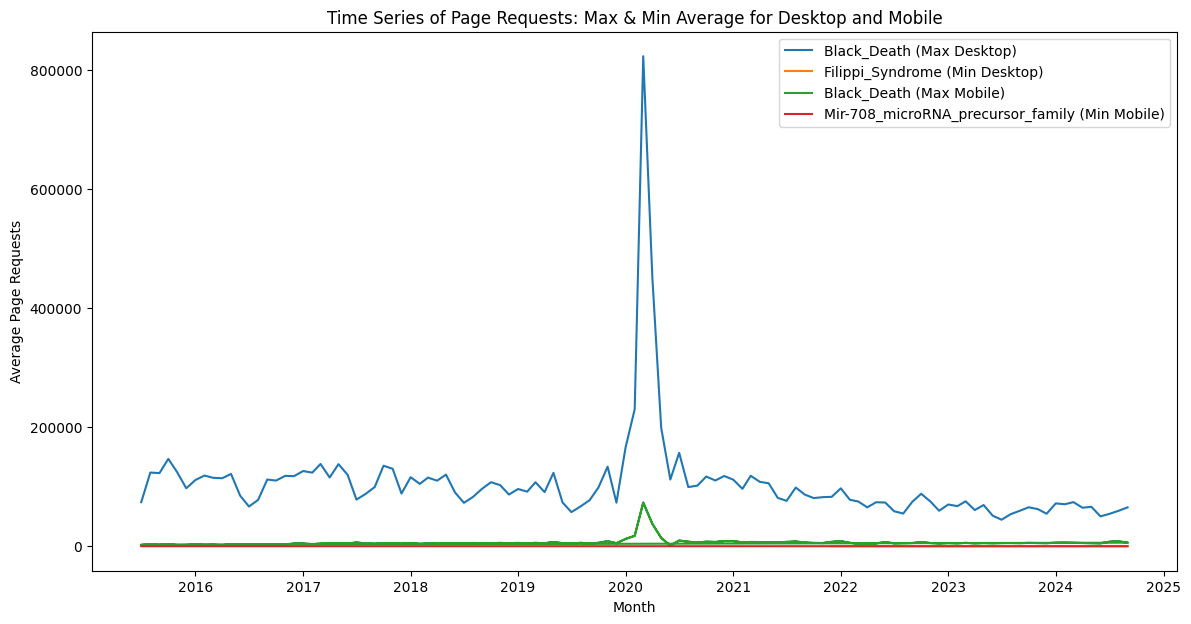

In [106]:
plt.figure(figsize=(14, 7))

plt.plot(max_desktop_data['timestamp'], max_desktop_data['views'], label=max_desktop['article'] + ' (Max Desktop)')
plt.plot(min_desktop_data['timestamp'], min_desktop_data['views'], label=min_desktop['article'] + ' (Min Desktop)')
plt.plot(max_mobile_data['timestamp'], max_mobile_data['views'], label=max_mobile['article'] + ' (Max Mobile)')
plt.plot(min_mobile_data['timestamp'], min_mobile_data['views'], label=min_mobile['article'] + ' (Min Mobile)')

plt.title('Time Series of Page Requests: Max & Min Average for Desktop and Mobile')
plt.xlabel('Month')
plt.ylabel('Average Page Requests')
plt.legend()
plt.show()


## Top 10 Peak Page Views

Identify the top 10 articles with the highest peak pageviews for both desktop and mobile

In [107]:
desktop_max = desktop_df.groupby('article')['views'].max().reset_index()
mobile_max = mobile_df.groupby('article')['views'].max().reset_index()

top_10_desktop = desktop_max.sort_values('views', ascending=False).head(10)
top_10_mobile = mobile_max.sort_values('views', ascending=False).head(10)

Filter top 10 articles by max views

In [108]:
top10_desktop_data = desktop_df[desktop_df['article'].isin(top_10_desktop['article'])]
top10_mobile_data = mobile_df[mobile_df['article'].isin(top_10_mobile['article'])]

desktop_max_timestamp = desktop_df.loc[desktop_df.groupby('article')['views'].idxmax()]
top_10_desktop_timestamp = desktop_max_timestamp[desktop_max_timestamp['article'].isin(top_10_desktop['article'])].nlargest(10, 'views')

mobile_max_timestamp = mobile_df.loc[mobile_df.groupby('article')['views'].idxmax()]
top_10_mobile_timestamp = mobile_max_timestamp[mobile_max_timestamp['article'].isin(top_10_mobile['article'])].nlargest(10, 'views')

Visualize the time series of pageview trends for the top 10 articles with the highest peak views, separated by desktop and mobile access

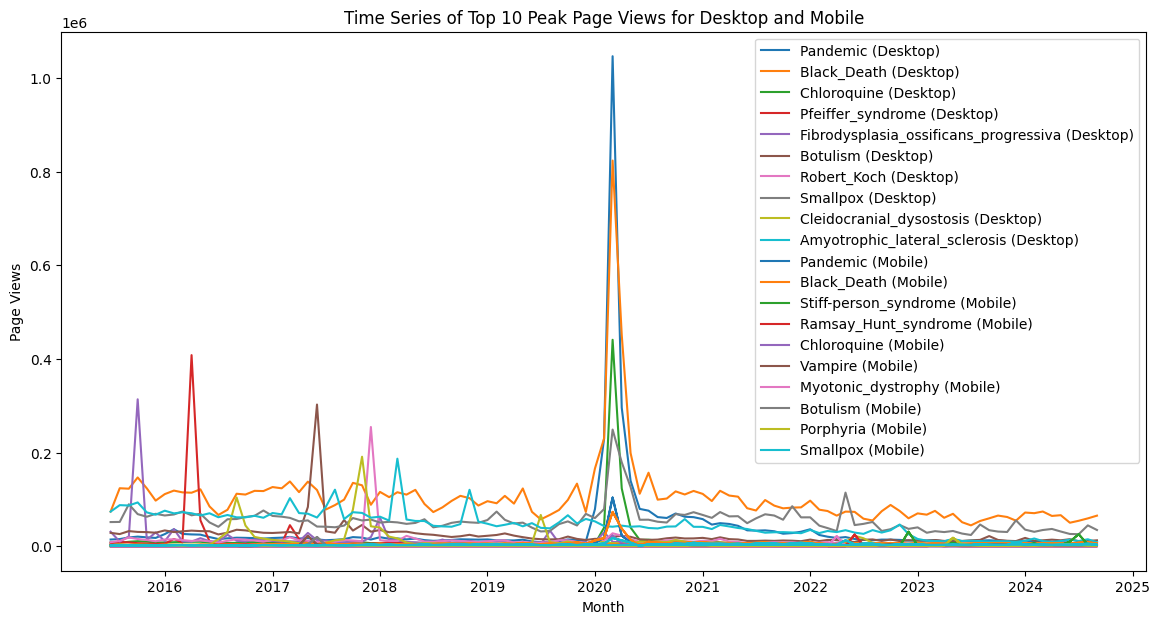

In [109]:
plt.figure(figsize=(14, 7))

for article in top_10_desktop_timestamp['article']:
    desktop_data = desktop_df[desktop_df['article'] == article]
    plt.plot(desktop_data['timestamp'], desktop_data['views'], label=f"{article} (Desktop)")

for article in top_10_mobile_timestamp['article']:
    mobile_data = mobile_df[mobile_df['article'] == article]
    plt.plot(mobile_data['timestamp'], mobile_data['views'], label=f"{article} (Mobile)")

plt.title('Time Series of Top 10 Peak Page Views for Desktop and Mobile')
plt.xlabel('Month')
plt.ylabel('Page Views')
plt.legend()
plt.show()


# Fewest Months of Data

Count the months of data for each article in the desktop and mobile, identifying the top ten articles with the fewest months of available data

In [110]:
desktop_monthly_counts = desktop_df.groupby('article')['year_month'].nunique().reset_index()
desktop_monthly_counts.rename(columns={'year_month': 'unique_month_count'}, inplace=True)
fewest_months_desktop = desktop_monthly_counts.sort_values('unique_month_count').head(10)

mobile_monthly_counts = mobile_df.groupby('article')['year_month'].nunique().reset_index()
mobile_monthly_counts.rename(columns={'year_month': 'unique_month_count'}, inplace=True)
fewest_months_mobile = mobile_monthly_counts.sort_values('unique_month_count').head(10)

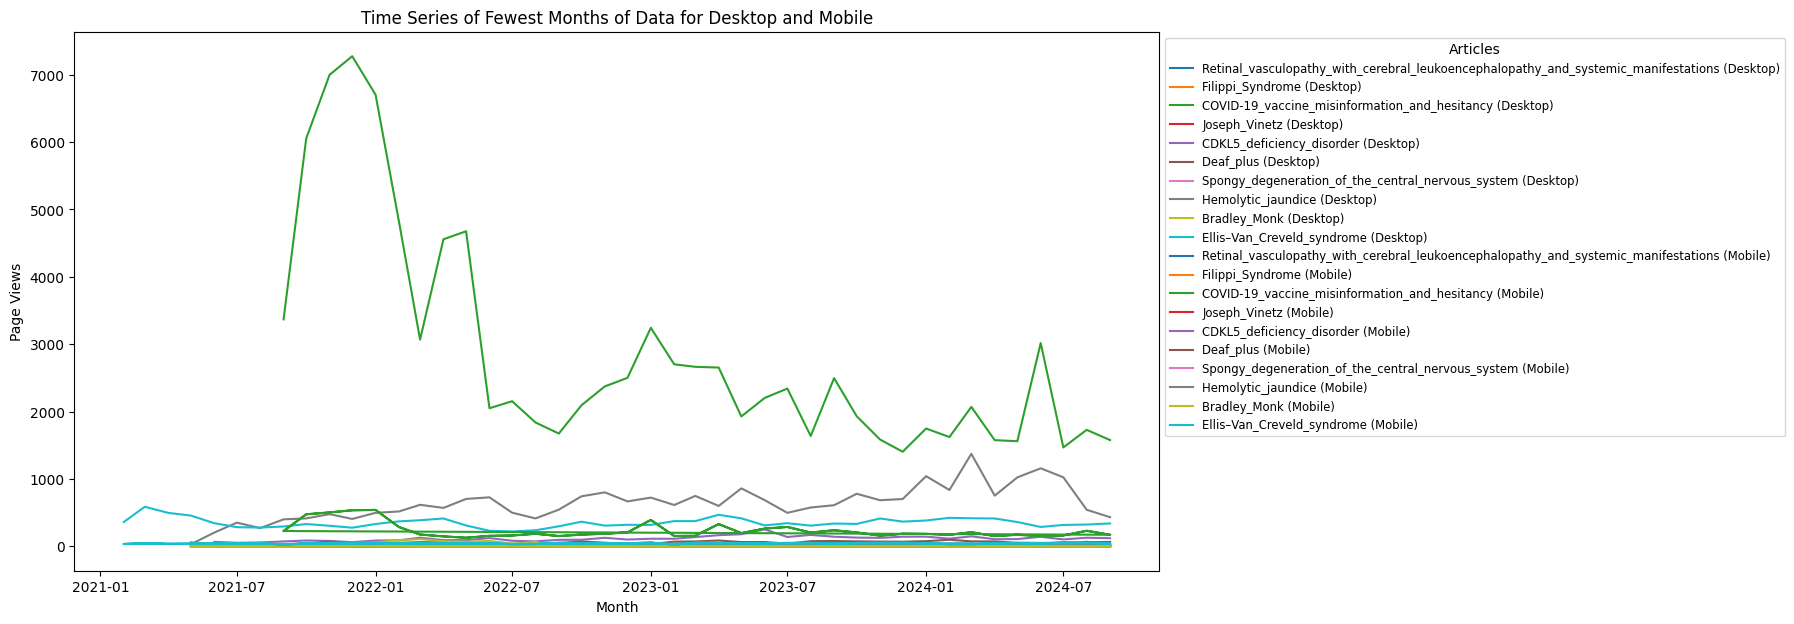

In [111]:
plt.figure(figsize=(14, 7))

for article in fewest_months_desktop['article']:
    desktop_data = desktop_df[desktop_df['article'] == article]
    plt.plot(desktop_data['timestamp'], desktop_data['views'], label=f"{article} (Desktop)")

for article in fewest_months_mobile['article']:
    mobile_data = mobile_df[mobile_df['article'] == article]
    plt.plot(mobile_data['timestamp'], mobile_data['views'], label=f"{article} (Mobile)")

plt.title('Time Series of Fewest Months of Data for Desktop and Mobile')
plt.xlabel('Month')
plt.ylabel('Page Views')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1), title='Articles', fontsize='small')
plt.show()